In [63]:
import numpy as np
import matplotlib.pyplot as plt

from tools import *
from poly import encode_poly_matrix, recovery_matrix_poly
from orthopoly import encode_cheb_matrix, recovery_matrix_cheb
from rkkp import encode_RKKP_matrix, recovery_matrix_RKKP
from strassen import Strassen_division, collect_Strassen_result

In [24]:
RANDOM_STATE = None

In [26]:
def poly_experiment(m, n, N, A, B, straglers=0, verbose=False):
    C = A.T @ B

    if verbose:
        print('A, B, C:', end='\n\n')
        print(A, B, C, sep='\n\n')

    A_parts = split_matrix(A, m)
    B_parts = split_matrix(B, n)
    l, p = A.shape[1] // m, B.shape[1] // n

    A_tilda = encode_poly_matrix(A_parts, N, 1)
    B_tilda = encode_poly_matrix(B_parts, N, m)

    A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=RANDOM_STATE)

    C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
    C_tilda = np.vstack(C_tilda)

    C_rec = recovery_matrix_poly(C_tilda, N, m*n, saved_nodes, l, p, m)

    if verbose:
        print('\nC_rec, C:', end='\n\n')
        print(C_rec, C, sep='\n\n')

    nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
    return nmse


def orthopoly_experiment(m, n, N, A, B, straglers=0, verbose=False):
    r = A.shape[1]
    t = B.shape[1]
    C = A.T @ B
    
    x = np.arange(1, N + 1)
    x = np.cos((2*x - 1) * np.pi / 2 / N)

    if verbose:
        print('A, B, C:', end='\n\n')
        print(A, B, C, sep='\n\n')

    A_parts = split_matrix(A, m)
    B_parts = split_matrix(B, n)
    
    l, p = r // m, t // n

    A_tilda = encode_cheb_matrix(A_parts, N, 1, x)
    B_tilda = encode_cheb_matrix(B_parts, N, m, x)

    A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=RANDOM_STATE)

    C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
    C_tilda = np.vstack(C_tilda)

    C_rec = recovery_matrix_cheb(C_tilda, m, n, saved_nodes, x, l, p)

    if verbose:
        print('\nC_rec, C:', end='\n\n')
        print(C_rec, C, sep='\n\n')

    nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
    return nmse


def RKKP_experiment(m, n, N, A, B, straglers=0, verbose=False):
    r = A.shape[1]
    t = B.shape[1]
    C = A.T @ B
    
    x = np.arange(1, N + 1)
    x = np.cos((2*x - 1) * np.pi / 2 / N)

    if verbose:
        print('A, B, C:', end='\n\n')
        print(A, B, C, sep='\n\n')

    A_parts = split_matrix(A, m)
    B_parts = split_matrix(B, n)
    
    l, p = r // m, t // n

    A_tilda, P = encode_RKKP_matrix(A_parts, N)
    B_tilda, Q = encode_RKKP_matrix(B_parts, N)

    A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=RANDOM_STATE)

    C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
    C_tilda = np.vstack(C_tilda)

    C_rec = recovery_matrix_RKKP(C_tilda, saved_nodes, P, Q, l, p)

    if verbose:
        print('\nC_rec, C:', end='\n\n')
        print(C_rec, C, sep='\n\n')

    nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
    return nmse

## Poly code

In [50]:
m, n = 2, 2
N = 4

s = 4
r = 4
t = 4

A = np.random.rand(s, r)
B = np.random.rand(s, t)

In [51]:
print('NMSE:', poly_experiment(m, n, N, A, B, straglers=0, verbose=False))

NMSE: 1.2511050820032687e-13


## Cond of Vandermonde matrix

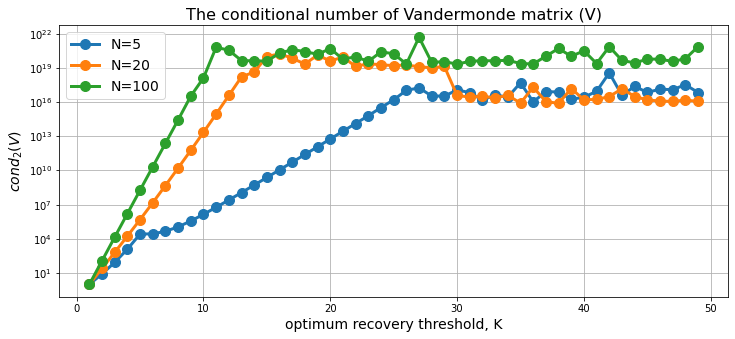

In [28]:
def calculate_cond_vander(N, grid):
    cond_vander = []
    alphas = np.arange(1, N+1)
    for m in grid:
        vand = np.vander(alphas, m, increasing=True) #Size of the Vandermonde matrix
        cond_vander.append(np.linalg.cond(vand))   
    
    return cond_vander


rec_thr = np.arange(1, 50)
cond_vander = {}

Ns = [5, 20, 100]
cond_vander = {n: calculate_cond_vander(n, rec_thr) for n in Ns}
    

plt.figure(figsize=((12, 5)))
plt.grid() 

for N in Ns:
    plt.plot(rec_thr, cond_vander[N],  marker='o', lw=3, markersize=10, label=f'N={N}')

plt.xlabel("optimum recovery threshold, K", fontsize=14)
plt.ylabel("$cond_2(V)$", fontsize=14)
plt.yscale("log")
plt.title("The conditional number of Vandermonde matrix (V)", fontsize=16)
plt.legend(loc='best', fontsize=14)
# plt.savefig("graph_cond_of_vander")

## Cheb

In [52]:
m, n = 2, 2
N = 4

s = 4
r = 4
t = 4

A = np.random.rand(s, r)
B = np.random.rand(s, t)

In [54]:
print('NMSE:', orthopoly_experiment(m, n, N, A, B, straglers=0, verbose=False))

NMSE: 4.685543171388235e-16


In [55]:
from orthopoly import generate_matrix_H
import numpy.polynomial.chebyshev as cheb


def calculate_cond_cheb_vander(N, grid):
    cond_cheb_vander = []
    x = np.arange(1, N + 1)
    x = np.cos((2*x - 1) * np.pi / 2 / N)

    for m in grid:
        chebvander = cheb.chebvander(x, m**2 - 1).astype(np.float64) #Size of the Vandermonde matrix
        H = generate_matrix_H(m, m)
        cond_cheb_vander.append(np.linalg.cond(chebvander @ H)) 

    return cond_cheb_vander


rec_thr = np.arange(2, 9)
cond_cheb_vander = {n: calculate_cond_cheb_vander(n, rec_thr) for n in Ns} 

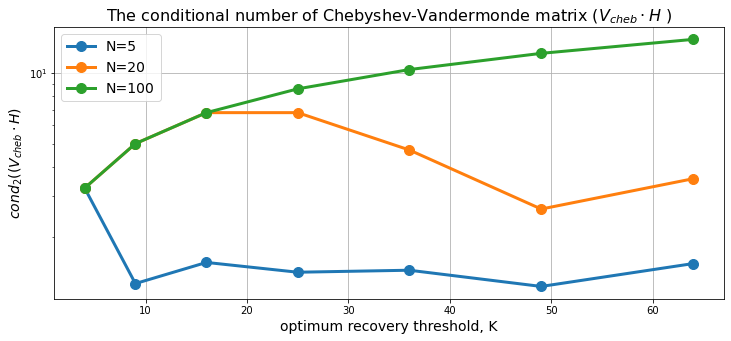

In [56]:
plt.figure(figsize=((12, 5)))
plt.grid() 

for N in Ns:
    plt.plot(rec_thr**2, cond_cheb_vander[N],  marker='o', lw=3, markersize=10, label=f'N={N}')

plt.xlabel("optimum recovery threshold, K", fontsize=14)
plt.ylabel("$cond_2((V_{cheb} \cdot H)$", fontsize=14)
plt.yscale("log")
#plt.xscale('log')
plt.title("The conditional number of Chebyshev-Vandermonde matrix $(V_{cheb} \cdot H$ )", fontsize=16)
plt.legend(loc='best', fontsize=14)
# plt.savefig("graph_cond_of_vander")

## RKKP codes

In [50]:
m, n = 2, 2
N = 4

s = 4
r = 4
t = 4

A = np.random.rand(s, r)
B = np.random.rand(s, t)

In [57]:
print('NMSE:', RKKP_experiment(m, n, N, A, B, straglers=2, verbose=False))

NMSE: 4.802235573502673e-16


In [59]:
from scipy.linalg import khatri_rao


def calculate_cond_RKKP(N, grid):
    cond_RKKP = []
    
    for m in grid:
        P = np.random.rand(m, N)
        Q = np.random.rand(m, N)
        G = khatri_rao(P, Q).T

        cond_RKKP.append(np.linalg.cond(G))

    return cond_RKKP

Ns = [5, 20, 100]
rec_thr = np.arange(2, 10)
cond_RKKP = {n: calculate_cond_RKKP(n, rec_thr) for n in Ns}

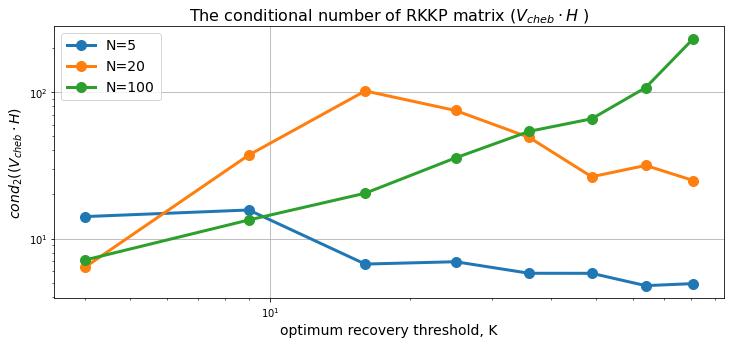

In [60]:
plt.figure(figsize=((12, 5)))
plt.grid() 

for N in Ns:
    plt.plot(rec_thr**2, cond_RKKP[N], marker='o', lw=3, markersize=10, label=f'N={N}')

plt.xlabel("optimum recovery threshold, K", fontsize=14)
plt.ylabel("$cond_2((V_{cheb} \cdot H)$", fontsize=14)
plt.yscale("log")
plt.xscale('log')
plt.title("The conditional number of RKKP matrix $(V_{cheb} \cdot H$ )", fontsize=16)
plt.legend(loc='best', fontsize=14)

In [60]:
rec_thr = np.arange(2, 107, 7)
rec_thr_sqt = np.arange(2, 11)
Ns = [5, 20, 100]

cond_vander = {n: calculate_cond_vander(n, rec_thr) for n in Ns}
cond_cheb_vander = {n: calculate_cond_cheb_vander(n, rec_thr_sqt) for n in Ns} 
cond_RKKP = {n: calculate_cond_RKKP(n, rec_thr_sqt) for n in Ns}

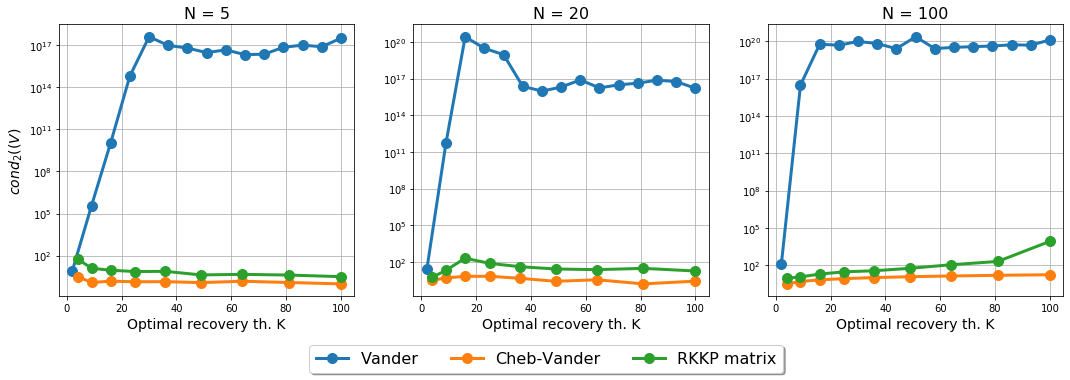

In [61]:
fig, axis = plt.subplots(1, len(Ns), figsize=(18, 5))

for ax, n in zip(axis, Ns):
    ax.plot(rec_thr, cond_vander[n], marker='o', lw=3, markersize=10, label='Vander')
    ax.plot(rec_thr_sqt**2, cond_cheb_vander[n], marker='o', lw=3, markersize=10, label='Cheb-Vander')
    ax.plot(rec_thr_sqt**2, cond_RKKP[n], marker='o', lw=3, markersize=10, label='RKKP matrix')
    
    ax.set_xlabel('Optimal recovery th. K', fontsize=14)
    ax.set_yscale('log')
    ax.set_title(f'N = {n}', fontsize=16)
    ax.grid()

axis[0].set_ylabel("$cond_2((V)$", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(-0.75, -0.15),
              fancybox=True, shadow=True, ncol=3, fontsize=16)

In [69]:
def calculate_nmse(m, n, n_straglers, s, r, t):
    A = np.random.rand(s, r)
    B = np.random.rand(s, t)
    
    poly_nmse = [poly_experiment(m, n, ns + m*n, A, B, straglers=ns, verbose=False) 
                 for ns in n_straglers]  
    orthopoly_nmse = [orthopoly_experiment(m, n, ns + m*n, A, B, straglers=ns, verbose=False) 
                      for ns in n_straglers]
    rkkp_nmse = [RKKP_experiment(m, n, ns + m*n, A, B, straglers=ns, verbose=False) 
                 for ns in n_straglers] 

    return np.array(poly_nmse), np.array(orthopoly_nmse), np.array(rkkp_nmse)


n_straglers = np.arange(0, 31)
nmses = np.array([calculate_nmse(7, 7, n_straglers, 21, 49 * 4, 49 * 4) for _ in range(10)])
nmses_mean = nmses.mean(axis=0)
nmses_std = nmses.mean(axis=0)

In [70]:
poly_nmse = nmses_mean[0]
orthopoly_nmse = nmses_mean[1]
rkkp_nmse = nmses_mean[2]

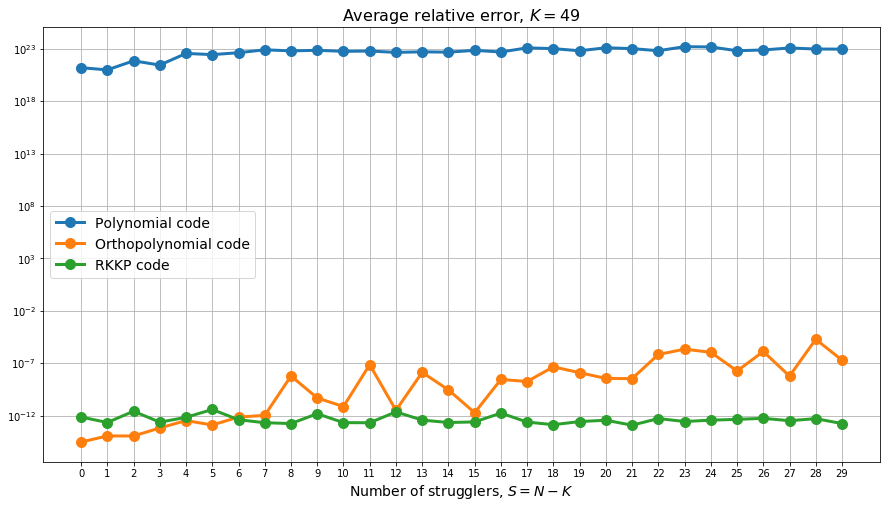

In [71]:
K = 49

plt.figure(figsize=((15, 8)))
plt.grid() 

end = 30

plt.plot(n_straglers[:end], poly_nmse[:end], marker='o', lw=3, markersize=10, label=f'Polynomial code')
plt.plot(n_straglers[:end], orthopoly_nmse[:end], marker='o', lw=3, markersize=10, label=f'Orthopolynomial code')
plt.plot(n_straglers[:end], rkkp_nmse[:end], marker='o', lw=3, markersize=10, label=f'RKKP code')
plt.xlabel("Number of strugglers, $S=N-K$", fontsize=14)
# plt.ylabel("", fontsize=14)
plt.yscale("log")
plt.title(f"Average relative error, $K = {K}$", fontsize=16)
plt.legend(loc='center left', fontsize=14)
plt.xticks(n_straglers[:end])

# plt.savefig("graph_average_relative_error")

plt.show()

# Parallel Strassen algorithm

In [64]:
s = 4
r = 4
t = 4

A = np.random.randint(1, 9, (s, r))
B = np.random.randint(1, 9, (s, t))
C = A.T @ B

In [65]:
S, Q = Strassen_division(A.T, B)
P = [s @ q for s, q in zip(S, Q)]
C_rec = collect_Strassen_result(P)

C_rec

array([[ 26,  19,  16,  35],
       [ 60,  26,  52,  84],
       [ 98,  47,  79, 115],
       [100,  54,  81, 116]])